In [75]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time


In [76]:
def get_label_of_class_id(filepath, target_id, value_name):
    try:
        with open(filepath, "r") as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: File not found: {filepath}")
        return None
    except IOError:
        print(f"Error: Could not read the file: {filepath}")
        return None
    found_target = False
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("id:") and int(line.split(":")[1].strip()) == target_id:
            found_target = True
            cls_name = (lines[i+1].strip(""))
            cls_name = cls_name.split(":")[1].strip().replace('"', '')
            return cls_name

    if not found_target:
        return None

#labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')


In [77]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1, useYOLOClasses = False):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    print(scores[i])
    print(class_names[i])
    if scores[i].numpy().any() >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i][:4])
      if useYOLOClasses:
        display_str = get_class_name(class_names[i]) + ": " + str(int(100 * scores[i])) + "%"
      else:
        display_str = get_label_of_class_id(labels_path, class_names[i], "display_name") + ": " + str(int(100 * scores[i])) + "%"
      #color = colors[hash(class_names[i]) % len(colors)]
      color = colors[hash(int(class_names[i].numpy())) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [78]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.expand_dims(img, axis=0)
  return img

In [79]:
#efficientdet: D1
#link https://www.kaggle.com/models/tensorflow/efficientdet/tensorFlow2/d1
detector = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/TensorFlow2/d1/1")
labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')

In [ ]:
# EfficientDet do
#link https://www.kaggle.com/models/tensorflow/efficientdet/tensorFlow2/d0
detector = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/TensorFlow2/d0/1")
labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')

In [11]:
#SSDMobileNetV2
#link https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/tensorFlow2/ssd-mobilenet-v2
# Apply image detector on a single image.
detector = hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/TensorFlow2/ssd-mobilenet-v2/1")
labels_path = tf.keras.utils.get_file(fname='labels.txt',origin='https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt')

In [16]:
#FasterRCNN with REsnet 50
#link https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2
detector = hub.load("https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/TensorFlow2/1024x1024/1")

In [19]:
#FasterRCNN resnet v1
#link : https://www.kaggle.com/models/tensorflow/faster-rcnn-resnet-v1
detector = hub.load("https://www.kaggle.com/models/tensorflow/faster-rcnn-resnet-v1/TensorFlow2/faster-rcnn-resnet101-v1-1024x1024/1")

In [23]:
#centernet with hourglass
#link https://www.kaggle.com/models/tensorflow/centernet-hourglass
detector = hub.load("https://www.kaggle.com/models/tensorflow/centernet-hourglass/TensorFlow2/1024x1024/1")

In [80]:
image_tensor = load_img("/content/motorcycle.jpeg")
start_time = time.time()
detector_output = detector(image_tensor)
end_time = time.time()
elapsed_time = end_time - start_time
print("Inference time: " + str(elapsed_time) + " seconds")
class_ids = detector_output["detection_classes"]

Inference time: 7.320364713668823 seconds


tf.Tensor(0.90791214, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


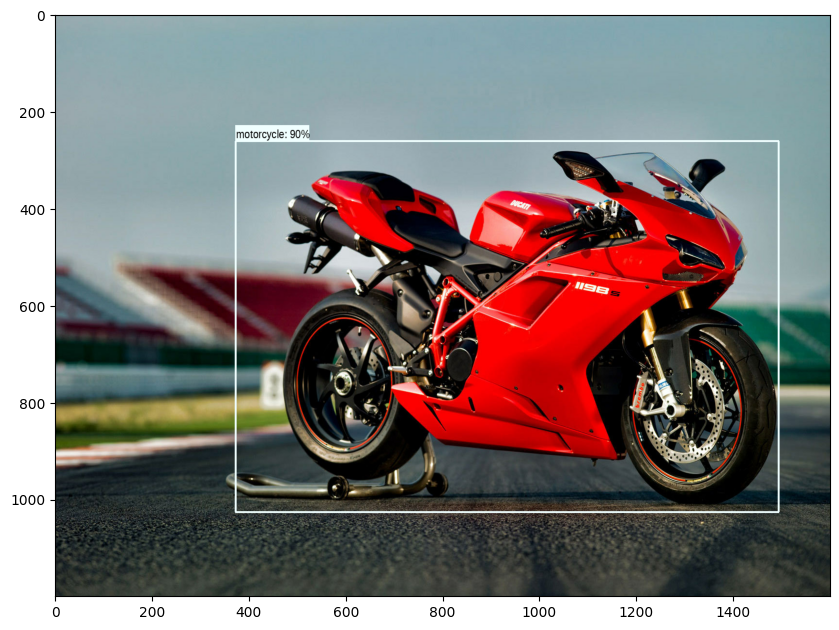

In [81]:
image_with_boxes = draw_boxes(
    image_tensor[0].numpy(), detector_output["detection_boxes"][0],
    class_ids[0], detector_output["detection_scores"][0],max_boxes=1, min_score=0.1)

plt.figure(figsize=(10,10))
plt.imshow(image_with_boxes)
plt.show()

In [26]:
!pip install ultralytics==8.2.103 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 15.5 MB/s eta 0:00:00


In [27]:
# YOLO
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.0/107.7 GB disk)


In [28]:
from ultralytics import YOLO

In [72]:
# prompt: can you please write code for bounding box and class with confidence on image

import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
names = {
    0: "person",
    1: "bicycle",
    2: "car",
    3: "motorcycle",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",
    8: "boat",
    9: "traffic light",
    10: "fire hydrant",
    11: "stop sign",
    12: "parking meter",
    13: "bench",
    14: "bird",
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    24: "backpack",
    25: "umbrella",
    26: "handbag",
    27: "tie",
    28: "suitcase",
    29: "frisbee",
    30: "skis",
    31: "snowboard",
    32: "sports ball",
    33: "kite",
    34: "baseball bat",
    35: "baseball glove",
    36: "skateboard",
    37: "surfboard",
    38: "tennis racket",
    39: "bottle",
    40: "wine glass",
    41: "cup",
    42: "fork",
    43: "knife",
    44: "spoon",
    45: "bowl",
    46: "banana",
    47: "apple",
    48: "sandwich",
    49: "orange",
    50: "broccoli",
    51: "carrot",
    52: "hot dog",
    53: "pizza",
    54: "donut",
    55: "cake",
    56: "chair",
    57: "couch",
    58: "potted plant",
    59: "bed",
    60: "dining table",
    61: "toilet",
    62: "tv",
    63: "laptop",
    64: "mouse",
    65: "remote",
    66: "keyboard",
    67: "cell phone",
    68: "microwave",
    69: "oven",
    70: "toaster",
    71: "sink",
    72: "refrigerator",
    73: "book",
    74: "clock",
    75: "vase",
    76: "scissors",
    77: "teddy bear",
    78: "hair drier",
    79: "toothbrush"
}
  # Placeholder function – replace with your actual class name retrieval method
def get_class_name(class_id):
    # Example: using a dictionary mapping class IDs to names
    #class_names = names[class_id]
    return names.get(class_id, "Unknown")

def plot_bounding_boxes(image_path, results):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
    for box in results[0].boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
        confidence = box.conf[0]
        class_id = int(box.cls[0])
        class_name = get_class_name(class_id)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        text = f"{class_name} {confidence:.2f}"
        draw.text((x1, y1), text, fill="red", font=font)

    img.show()
    return img



image 1/1 /content/motorcycle.jpeg: 480x640 1 motorcycle, 197.3ms
Speed: 3.6ms preprocess, 197.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Inference time: 0.31976842880249023 seconds
after compl


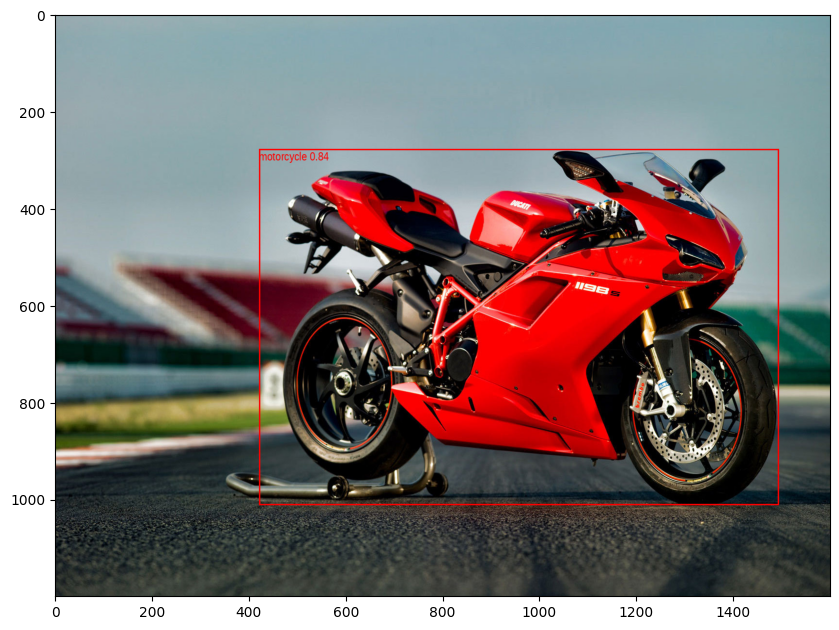

In [83]:
model = YOLO("/content/yolov8n.pt")
start_time = time.time()
results = model.predict(source="/content/motorcycle.jpeg", conf=0.25)
end_time = time.time()
elapsed_time = end_time - start_time
print("Inference time: " + str(elapsed_time) + " seconds")
img = plot_bounding_boxes("/content/motorcycle.jpeg", results)
plt.figure(figsize=(10,10)) #added for showing image in colab
plt.imshow(img) #added for showing image in colab
plt.show() #added for showing image in colab
